# Temporal, Voting-Based Classification of Coral vs. Algae

Given the similarity in the spectral signatures of Coral and Algae, it is very hard to distinguish between the two using satellite data. For this reason, many previous studies have grouped coral and algae into one class, including Allen Coral Atlas, one of the most extensive data sources on coral across the planet. However, distinguishing between coral and algae is desirable in building a robust system for monitoring the health of reefs around the globe.

In this notebook, we experiment with a method that uses domain knowledge about the seasonal presence of algae to try to distinguish between coral and algae. This is based on the fact that algae is typically present in the warm, summer months but not in the colder months. The idea is to take a model trained on Allen Coral Atlas data to predict the coral/algae class, predict over the same point at different time intervals throughout the year and create a temporal, voting-based algorithm for distinguishing between coral and algae. We will begin by loading in the necessary packages

### Loading Packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import ee
#!pip install eemont
import eemont
import datetime

### Loading in Pre-Trained Coral/Algae Detection Model

In [17]:
# loading model from pickle file
xgb_model = pickle.load(open("./coral_presence_xgb_model_CAR_10km.pkl", "rb"))

### Authenticating and Initializing Google Earth Engine Connection to Pull Necessary Satellite Data for a Given Lat/Long Point

In [18]:
ee.Authenticate()
ee.Initialize()

### Defining a Function to Pull the MODIS Data Used as Features in the Coral/Algae Detection Model
The function below uses Google Earth Engine to pull the surface reflectance features from MODIS that were used to train our coral/algae detection model

In [19]:
from ee import EEException
def getModisData(row):
    try:
        modis = ee.ImageCollection("MODIS/006/MYDOCGA").select(['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11',
                                                                                'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 
                                                                                'sur_refl_b15', 'sur_refl_b16'])
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        image = modis.filterBounds(geometry=ee.Geometry.Point([row['long'], row['lat']])).filterDate(date, date.advance(30, 'day'))
        data = image.getRegion(geometry=ee.Geometry.Point([row['long'], row['lat']]), scale=1000).getInfo()
        df = pd.DataFrame(data[1:], columns=data[0])
        df.replace(-100, np.nan, inplace=True)
        df.dropna(inplace=True)
        if df.shape[0] > 1:
            row['sur_refl_b08'] = df.iloc[0,]['sur_refl_b08']
            row['sur_refl_b09'] = df.iloc[0,]['sur_refl_b09']
            row['sur_refl_b10'] = df.iloc[0,]['sur_refl_b10']
            row['sur_refl_b11'] = df.iloc[0,]['sur_refl_b11']
            row['sur_refl_b12'] = df.iloc[0,]['sur_refl_b12']
            row['sur_refl_b13'] = df.iloc[0,]['sur_refl_b13']
            row['sur_refl_b14'] = df.iloc[0,]['sur_refl_b14']
            row['sur_refl_b15'] = df.iloc[0,]['sur_refl_b15']
            row['sur_refl_b16'] = df.iloc[0,]['sur_refl_b16']

        elif df.shape[0]==1:
            row['sur_refl_b08'] = df.iloc[0,]['sur_refl_b08']
            row['sur_refl_b09'] = df.iloc[0,]['sur_refl_b09']
            row['sur_refl_b10'] = df.iloc[0,]['sur_refl_b10']
            row['sur_refl_b11'] = df.iloc[0,]['sur_refl_b11']
            row['sur_refl_b12'] = df.iloc[0,]['sur_refl_b12']
            row['sur_refl_b13'] = df.iloc[0,]['sur_refl_b13']
            row['sur_refl_b14'] = df.iloc[0,]['sur_refl_b14']
            row['sur_refl_b15'] = df.iloc[0,]['sur_refl_b15']
            row['sur_refl_b16'] = df.iloc[0,]['sur_refl_b16']
        elif df.shape[0]==0:
            row['sur_refl_b08'] = np.nan
            row['sur_refl_b09'] = np.nan
            row['sur_refl_b10'] = np.nan
            row['sur_refl_b11'] = np.nan
            row['sur_refl_b12'] = np.nan
            row['sur_refl_b13'] = np.nan
            row['sur_refl_b14'] = np.nan
            row['sur_refl_b15'] = np.nan
            row['sur_refl_b16'] = np.nan
        return row
    except EEException:
        row['sur_refl_b08'] = np.nan
        row['sur_refl_b09'] = np.nan
        row['sur_refl_b10'] = np.nan
        row['sur_refl_b11'] = np.nan
        row['sur_refl_b12'] = np.nan
        row['sur_refl_b13'] = np.nan
        row['sur_refl_b14'] = np.nan
        row['sur_refl_b15'] = np.nan
        row['sur_refl_b16'] = np.nan    
        return row

### Defining a Function to Pull the Landsat Data Used as Features in the Coral/Algae Detection Model
The function below uses Google Earth Engine to pull the Spectral Indices and Reflectance Band features from Landsat that were used to train our coral/algae detection model

In [21]:
def getLandsatData(row):
    try:
        satellite = 'Landsat'
        spec_idxs = [ 'NDWI']
        landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        satellite += '8'
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        data = landsat.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'])\
                       .spectralIndices(spec_idxs)\
                       .filterBounds(geometry=ee.Geometry.Point([row['long'], row['lat']]))\
                       .filterDate(date, date.advance(30, 'day'))\
                       .getRegion(geometry=ee.Geometry.Point([row['long'], row['lat']]), scale=100)\
                       .getInfo()
        df = pd.DataFrame(data[1:], columns = data[0])
        mapping = {df.columns[4]: 'Blue', 
                   df.columns[5]: 'Green',
                   df.columns[6]: 'Red',
                   df.columns[7]: 'Near Infrared',
                   df.columns[8]: 'Shortwave Infrared 1',
                   df.columns[9]: 'Shortwave Infrared 2'}
        df = df.rename(columns=mapping)
        df = df.dropna()
        df['datetime'] = df.time.apply(lambda x: datetime.datetime.fromtimestamp(x/1000))

        if df.shape[0] > 1:
            time_deltas = {}
            for i in range(df.shape[0]):
                time_deltas[i] = np.abs(pd.to_datetime(df['datetime'].values[i]) - row['date'])
            ind = min(time_deltas, key=time_deltas.get)

            row['Blue'] = df.iloc[ind,]['Blue']
            row['Green'] = df.iloc[ind,]['Green']
            row['Red'] = df.iloc[ind,]['Red']
            row['Near Infrared'] = df.iloc[ind,]['Near Infrared']
            row['Shortwave Infrared 1'] = df.iloc[ind,]['Shortwave Infrared 1']
            row['Shortwave Infrared 2'] = df.iloc[ind,]['Shortwave Infrared 2']
            row['QA_PIXEL'] = df.iloc[ind,]['QA_PIXEL']
            #row['AWEInsh'] = df.iloc[ind,]['AWEInsh']
            #row['AWEIsh'] = df.iloc[ind,]['AWEIsh']
            #row['LSWI'] = df.iloc[ind,]['LSWI']
            #row['MBWI'] = df.iloc[ind,]['MBWI']
            #row['MLSWI26'] = df.iloc[ind,]['MLSWI26']
            #row['MLSWI27'] = df.iloc[ind,]['MLSWI27']
            #row['MNDWI'] = df.iloc[ind,]['MNDWI']
            #row['MuWIR'] = df.iloc[ind,]['MuWIR']
            row['NDWI'] = df.iloc[ind,]['NDWI']
            #row['NDWIns'] = df.iloc[ind,]['NDWIns']
            #row['NWI'] = df.iloc[ind,]['NWI']
            #row['SWM'] = df.iloc[ind,]['SWM']
            #row['WI1'] = df.iloc[ind,]['WI1']
            #row['WI2'] = df.iloc[ind,]['WI2']
            #row['WRI'] = df.iloc[ind,]['WRI']
            row['datetime_landsat'] = df.iloc[ind,]['datetime']
            row['datetime_landsat_offset'] = time_deltas[ind]

        elif df.shape[0]==1:
            row['Blue'] = df.iloc[0,]['Blue']
            row['Green'] = df.iloc[0,]['Green']
            row['Red'] = df.iloc[0,]['Red']
            row['Near Infrared'] = df.iloc[0,]['Near Infrared']
            row['Shortwave Infrared 1'] = df.iloc[0,]['Shortwave Infrared 1']
            row['Shortwave Infrared 2'] = df.iloc[0,]['Shortwave Infrared 2']
            row['QA_PIXEL'] = df.iloc[0,]['QA_PIXEL']
            #row['AWEInsh'] = df.iloc[0,]['AWEInsh']
            #row['AWEIsh'] = df.iloc[0,]['AWEIsh']
            #row['LSWI'] = df.iloc[0,]['LSWI']
            #row['MBWI'] = df.iloc[0,]['MBWI']
            #row['MLSWI26'] = df.iloc[0,]['MLSWI26']
            #row['MLSWI27'] = df.iloc[0,]['MLSWI27']
            #row['MNDWI'] = df.iloc[0,]['MNDWI']
            #row['MuWIR'] = df.iloc[0,]['MuWIR']
            row['NDWI'] = df.iloc[0,]['NDWI']
            #row['NDWIns'] = df.iloc[0,]['NDWIns']
            #row['NWI'] = df.iloc[0,]['NWI']
            #row['SWM'] = df.iloc[0,]['SWM']
            #row['WI1'] = df.iloc[0,]['WI1']
            #row['WI2'] = df.iloc[0,]['WI2']
            #row['WRI'] = df.iloc[0,]['WRI']
            row['datetime_landsat'] = df.iloc[0,]['datetime']
            row['datetime_landsat_offset'] = pd.to_datetime(df.iloc[0,]['datetime']) - datetime.datetime.strptime('2022-09-01', '%Y-%m-%d')

        elif df.shape[0]==0:
            row['Blue'] = np.nan
            row['Green'] = np.nan
            row['Red'] = np.nan
            row['Near Infrared'] = np.nan
            row['Shortwave Infrared 1'] = np.nan
            row['Shortwave Infrared 2'] = np.nan
            row['QA_PIXEL'] = np.nan
            #row['AWEInsh'] = np.nan
            #row['AWEIsh'] = np.nan
            #row['LSWI'] = np.nan
            #row['MBWI'] = np.nan
            #row['MLSWI26'] = np.nan
            #row['MLSWI27'] = np.nan
            #row['MNDWI'] = np.nan
            #row['MuWIR'] = np.nan
            row['NDWI'] = np.nan
            #row['NDWIns'] = np.nan
            #row['NWI'] = np.nan
            #row['SWM'] = np.nan
            #row['WI1'] = np.nan
            #row['WI2'] = np.nan
            #row['WRI'] = np.nan
            #ow['datetime_landsat'] = np.nan
            row['datetime_landsat_offset'] = np.nan
        return row

    except EEException:
        row['Blue'] = np.nan
        row['Green'] = np.nan
        row['Red'] = np.nan
        row['Near Infrared'] = np.nan
        row['Shortwave Infrared 1'] = np.nan
        row['Shortwave Infrared 2'] = np.nan
        row['QA_PIXEL'] = np.nan
        #row['AWEInsh'] = np.nan
        #row['AWEIsh'] = np.nan
        #row['LSWI'] = np.nan
        #row['MBWI'] = np.nan
        #row['MLSWI26'] = np.nan
        #row['MLSWI27'] = np.nan
        #row['MNDWI'] = np.nan
        #row['MuWIR'] = np.nan
        row['NDWI'] = np.nan
        #row['NDWIns'] = np.nan
        #row['NWI'] = np.nan
        #row['SWM'] = np.nan
        #row['WI1'] = np.nan
        #row['WI2'] = np.nan
        #row['WRI'] = np.nan
        row['datetime_landsat'] = np.nan
        row['datetime_landsat_offset'] = np.nan
        return row

### Defining a Function to Return Prediction Interval, and Voting-Based Classification for a Given Lat/Long Point
Given a latitude/longitude coordinate, the function below loads in the necessary features using Google Earth Engine, predicts over that point at various periods throughout the year, and provides a weighted average prediction of whether that point is coral/algae or not. The summer month predictions contribute less to the weighted average prediction due to the inability to distinguish between coral and algae in the summer months.

In [22]:
from scipy import stats
def get_prediction_interval(lat, lon, model, ci=.8):
    """
    Function to collect data and generate predictions throughout the year
    input: lat, long
    output: prediction interval, weighted average prediction 
    
    """
    dates = ['05/01/2021', '07/01/2021', '09/01/2021', '11/01/2021', '01/01/2022', '03/01/2022']
    df = pd.DataFrame()
    for date in dates:
        curr = pd.DataFrame({'date': [date], 'lat': [lat], 'long': [lon]})
        curr['date'] = pd.to_datetime(curr['date'])
        curr['day'] = curr['date'].dt.day
        curr['month'] = curr['date'].dt.month
        curr['year'] = curr['date'].dt.year
        df = pd.concat([df, curr])

    df = df.apply(getModisData, axis=1)
    df = df.apply(getLandsatData, axis=1)
    features = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'NDWI']
    X = df[features]
    preds = model.predict_proba(X)[:, 0]
    zipped = list(zip(preds, df['date']))
    if lat > 0:
        summer_start = datetime.datetime.strptime('2021-06-21', '%Y-%m-%d')
        summer_end = summer_start + datetime.timedelta(days=91)
    elif lat <0:
        summer_start = datetime.datetime.strptime('2021-12-01', '%Y-%m-%d')
        summer_end = summer_start + datetime.timedelta(days=91)
    weights = []
    for z in zipped:
        if z[1] > summer_start and z[1] < summer_end:
            weights.append(.5)
        else:
            weights.append(1)

    weighted_avg = np.average(preds, weights=weights)

    n = preds.shape[0]
    std = preds.std()
    interval = stats.t.interval(ci, n-1, loc=weighted_avg, scale=std)
    
    return preds, weighted_avg, interval, df['date'], summer_start, summer_end

### Example
With these functions defined, we can look at some examples and interpret them to determine whether the given point is coral, algae, or neither. For this first example, we will look at a point that is labeled as Coral/Algae from the Allen Coral Atlas

In [38]:
preds, predicted_probability, prediction_interval, dates, summer_start, summer_end = get_prediction_interval(lat=15.92413848, lon=-83.27242543, model=xgb_model)

Visualizing the model predictions over the year

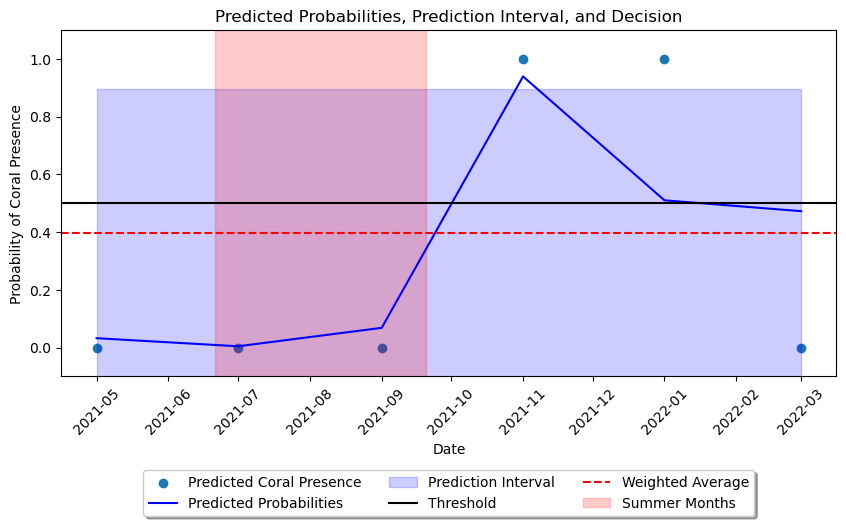

In [39]:
predicted_presence = np.round(preds).astype(int)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(dates, predicted_presence, label='Predicted Coral Presence')
ax.plot(dates, preds, color='blue', label='Predicted Probabilities')
ax.fill_between(dates, prediction_interval[0], prediction_interval[1], color='blue', alpha=.2, label='Prediction Interval')
plt.ylim([-0.1, 1.1])
ax.set_title('Predicted Probabilities, Prediction Interval, and Decision')
ax.set_ylabel('Probability of Coral Presence')
ax.set_xlabel('Date')
ax.axhline(y=.5, color='black', linestyle='-', label='Threshold')

if predicted_probability < .5:
    ax.axhline(y=predicted_probability, color='red', linestyle='--', label='Weighted Average')
else:
    ax.axhline(y=predicted_probability, color='green', linestyle='--', label='Weighted Average')
ax.axvspan(summer_start, summer_end, color='red', alpha=0.2, label=f'Summer Months')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3)
plt.xticks(rotation=45)
# ax.legend()
plt.show()

In [40]:
pred = round(predicted_probability)
start, stop = prediction_interval
print(f'Coral Presence: {pred} \n90% Prediction Interval for Probability of Coral Presence: {start:.4f}, {stop:.4f}\nWeighted Average Probability of Coral Presence: {predicted_probability:.4f}')

Coral Presence: 0 
90% Prediction Interval for Probability of Coral Presence: -0.1013, 0.8969
Weighted Average Probability of Coral Presence: 0.3978


Looking at the above output, we can see that the model predicts that this point is coral/algae in 5/6 time periods over the year, including outside the summer months. Based on this output, this is a point that using this method, we would label as **coral** since the weighted average probability is greater than .5.

### Example 2
With these functions defined, we can look at some examples and interpret them to determine whether the given point is coral, algae, or neither. For this example, we will look at another point that is labeled as Coral/Algae from the Allen Coral Atlas

In [41]:
preds, predicted_probability, prediction_interval, dates, summer_start, summer_end = get_prediction_interval(lat=22.53793692, lon=-89.70873933, model=xgb_model)

Visualizing the model predictions over the year

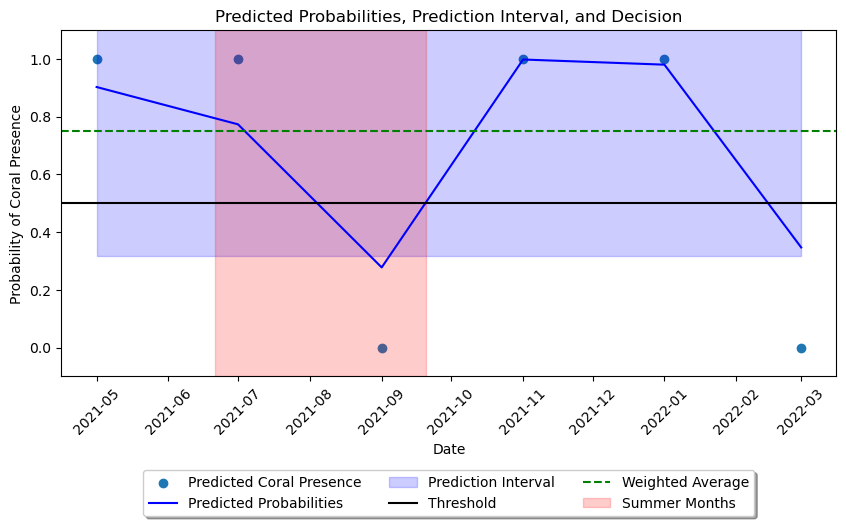

In [42]:
predicted_presence = np.round(preds).astype(int)
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(dates, predicted_presence, label='Predicted Coral Presence')
ax.plot(dates, preds, color='blue', label='Predicted Probabilities')
ax.fill_between(dates, prediction_interval[0], prediction_interval[1], color='blue', alpha=.2, label='Prediction Interval')
plt.ylim([-0.1, 1.1])
ax.set_title('Predicted Probabilities, Prediction Interval, and Decision')
ax.set_ylabel('Probability of Coral Presence')
ax.set_xlabel('Date')
#plotting a line at .5
ax.axhline(y=.5, color='black', linestyle='-', label='Threshold')
# plotting weighted average
if predicted_probability < .5:
    ax.axhline(y=predicted_probability, color='red', linestyle='--', label='Weighted Average')
else:
    ax.axhline(y=predicted_probability, color='green', linestyle='--', label='Weighted Average')
ax.axvspan(summer_start, summer_end, color='red', alpha=0.2, label=f'Summer Months')


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3)
plt.xticks(rotation=45)
# ax.legend()
plt.show()

In [43]:
pred = round(predicted_probability)
start, stop = prediction_interval
print(f'Coral Presence: {pred} \n90% Prediction Interval for Probability of Coral Presence: {start:.4f}, {stop:.4f}\nWeighted Average Probability of Coral Presence: {predicted_probability:.4f}')

Coral Presence: 1 
90% Prediction Interval for Probability of Coral Presence: 0.3176, 1.1827
Weighted Average Probability of Coral Presence: 0.7501


Looking at the above output, we can see that the model predicts that this point is coral/algae in only 2/6 time periods over the year, with one of those positive predictions being in the Summer time. Based on this output, this is a point that using this method, we would label as **algae** since the weighted average probability is less than .5.